In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io

df_base = pd.read_csv('CasoBase.csv')
df_agentes = pd.read_csv('CasoAgentes.csv')

In [91]:

# Renombrar columnas para que coincidan con el objetivo final
df_base = df_base.rename(columns={
    'ronda_num': 'round',
    'ganancia_neta_ronda': 'capital_change',
    'resultado_ronda': 'result',
    'cartas_restantes_mazo': 'cards_remaining'
})

# Seleccionar solo las columnas que necesitamos para la comparación
df_base = df_base[['round', 'agente_nombre', 'result', 'capital_change', 'cards_remaining']]

print("--- Datos estandarizados ---")
df_base.head()

--- Datos estandarizados ---


,round,agente_nombre,result,capital_change,cards_remaining
0,1,AgenteBasico,-1,-5,208
1,2,AgenteBasico,1,7,202
2,3,AgenteBasico,-1,-5,197
3,4,AgenteBasico,-1,-5,192
4,5,AgenteBasico,-1,-5,187


In [92]:
# "Derretimos" el DataFrame
# id_vars son las columnas que se mantienen fijas
# value_vars son las columnas que queremos convertir en filas
df_agentes_long = pd.melt(
    df_agentes,
    id_vars=['round', 'cards_remaining'],
    value_vars=[col for col in df_agentes.columns if col not in ['round', 'cards_remaining']],
    var_name='variable', # Nombre temporal para la columna que contiene 'markov_normal_result', etc.
    value_name='value'   # Nombre temporal para los valores
)

# Ahora separamos el nombre del agente y el tipo de métrica
df_agentes_long[['agente_nombre', 'metric']] = df_agentes_long['variable'].str.rsplit('.', n=1, expand=True)

# "Pivoteamos" la tabla para que 'result' y 'capital_change' vuelvan a ser columnas
df_agentes_final = df_agentes_long.pivot_table(
    index=['round', 'cards_remaining', 'agente_nombre'],
    columns='metric',
    values='value'
).reset_index()

# Limpiamos los nombres de las columnas del pivote
df_agentes_final.columns.name = None

print("--- Datos de Agente Estandarizados ---")
df_agentes_final.head()

--- Datos de Agente Estandarizados ---


,round,cards_remaining,agente_nombre,capital_change,decision_time_ms,decisions,result
0,1,208,aleatorio1,-3.0,0.0,1.0,-1.0
1,1,208,aleatorio2,-8.0,0.0,2.0,-1.0
2,1,208,hilo,0.0,0.0,2.0,0.0
3,1,208,markov_arriesgado,-10.0,315.0,1.0,-1.0
4,1,208,markov_hibrido,0.0,5.0,2.0,0.0


In [93]:


# Renombramos la columna 'change' en df_agentes_final si aún no se ha hecho
if 'change' in df_agentes_final.columns:
    df_agentes_final = df_agentes_final.rename(columns={'change': 'capital_change'})

# Concatenamos ambos DataFrames. Pandas alineará las columnas y rellenará las faltantes con NaN.
df_final = pd.concat([df_base, df_agentes_final], ignore_index=True, sort=False)

# Ordenamos los datos para una mejor visualización y análisis
df_final = df_final.sort_values(by=['round', 'agente_nombre']).reset_index(drop=True)

# Borramos el markov politica
df_final = df_final[df_final['agente_nombre'] != 'markov_politica'].copy()

# Cambiamos hilo a HiLo
df_final['agente_nombre'] = df_final['agente_nombre'].replace('hilo', 'HiLo')

# Verificamos que las nuevas columnas ahora están presentes
df_final.head(10)

,round,agente_nombre,result,capital_change,cards_remaining,decision_time_ms,decisions
0,1,AgenteBasico,-1.0,-5.0,208,NaN,NaN
1,1,aleatorio1,-1.0,-3.0,208,0.0,1.0
2,1,aleatorio2,-1.0,-8.0,208,0.0,2.0
3,1,HiLo,0.0,0.0,208,0.0,2.0
4,1,markov_arriesgado,-1.0,-10.0,208,315.0,1.0
5,1,markov_hibrido,0.0,0.0,208,5.0,2.0
6,1,markov_normal,-1.0,-5.0,208,315.0,2.0
8,1,markov_umbral,-1.0,-5.0,208,2.0,1.0
9,1,randomforest,0.0,0.0,208,38.0,1.0
10,2,AgenteBasico,1.0,7.0,202,NaN,NaN


In [94]:
from matplotlib.ticker import PercentFormatter

Generando Gráfico 1: Tasa de Éxito Normalizada...


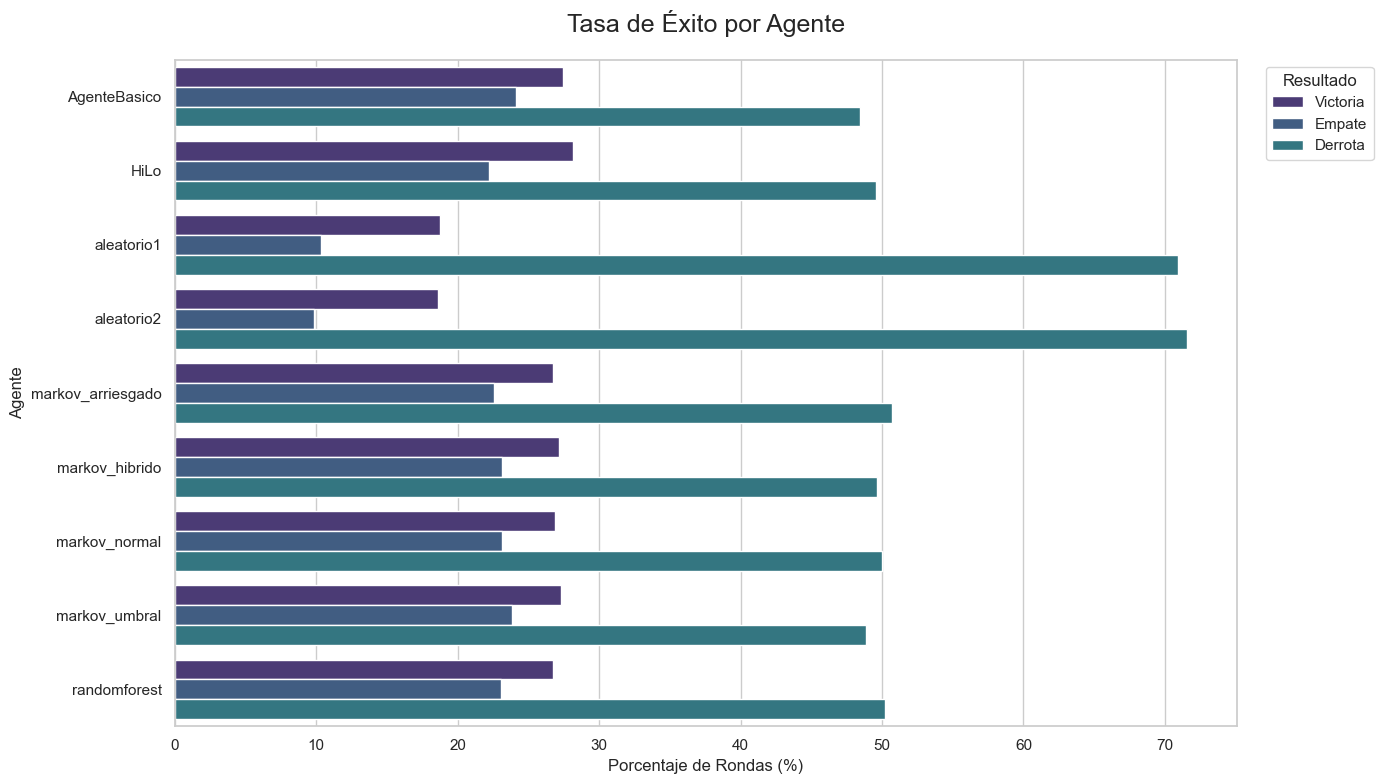

In [95]:
result_map = {-1.0: "Derrota", 0.0: "Empate", 1.0: "Victoria"}
df_final['result'] = df_final['result'].map(result_map)

# Establecer un tema visual agradable
sns.set_theme(style="whitegrid", palette="viridis")

print("Generando Gráfico 1: Tasa de Éxito Normalizada...")

# Agrupar por agente y resultado, contar, y luego calcular el porcentaje
df_summary = df_final.groupby('agente_nombre')['result'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(data=df_summary, x='percentage', y='agente_nombre', hue='result', hue_order=['Victoria', 'Empate', 'Derrota'])

plt.title('Tasa de Éxito por Agente', fontsize=18, pad=20)
plt.xlabel('Porcentaje de Rondas (%)')
plt.ylabel('Agente')
plt.legend(title='Resultado', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



Distribución de Ganancias


C:\Users\javie\AppData\Local\Temp\ipykernel_18360\832939722.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_filtrado, x='agente_nombre', y='capital_change', palette='coolwarm', inner='quartile')


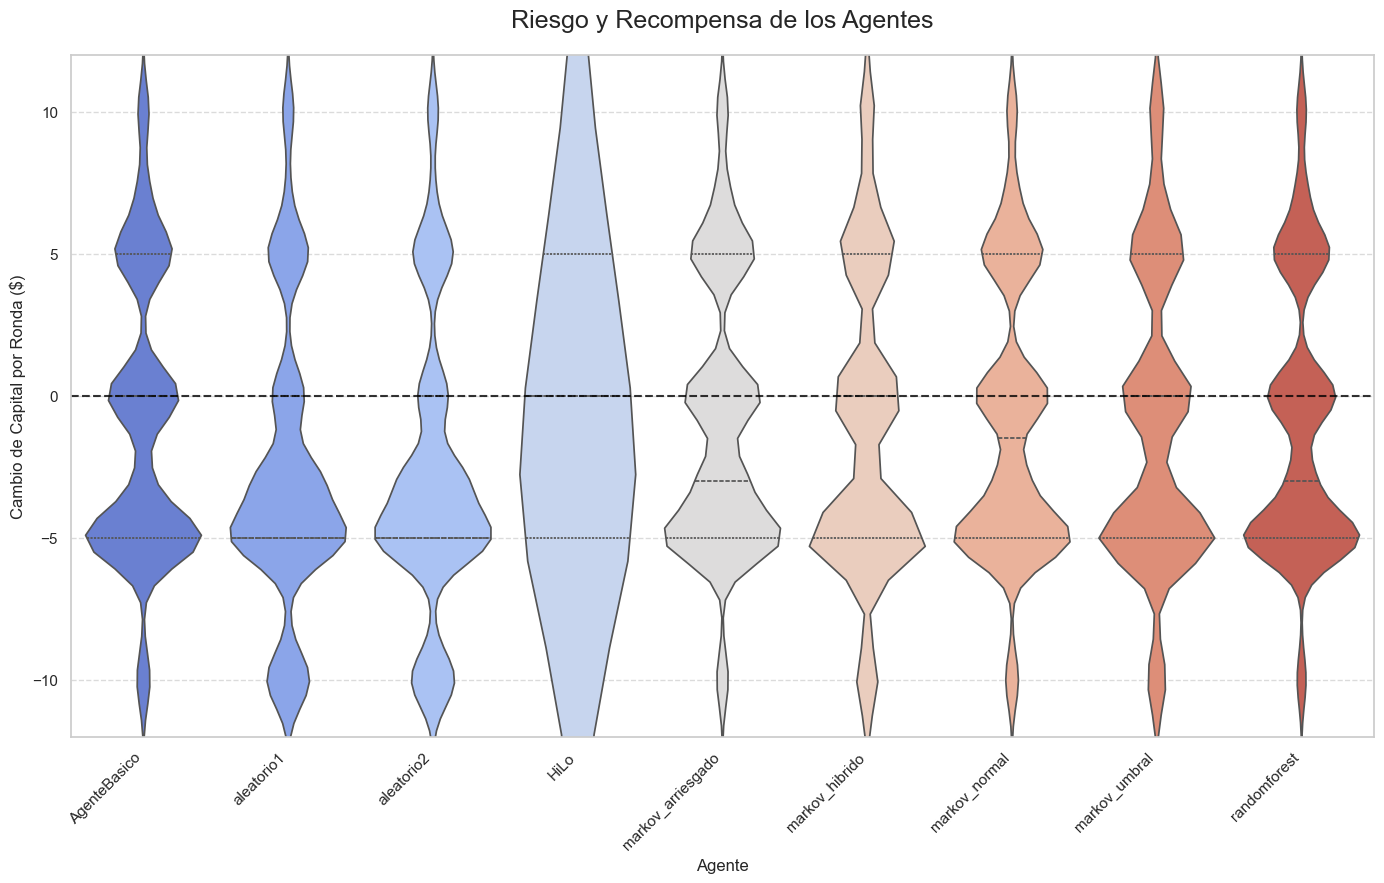

In [96]:
print("\nDistribución de Ganancias")

# Filtramos para excluir al agente con una escala de apuesta diferente
df_filtrado = df_final[df_final['agente_nombre'] != 'markov_politica'].copy()

plt.figure(figsize=(14, 9))

# Usamos split=True para crear "medios violines" si quisiéramos comparar otra categoría
sns.violinplot(data=df_filtrado, x='agente_nombre', y='capital_change', palette='coolwarm', inner='quartile')

# 'inner='quartile'' dibuja las líneas de los cuartiles dentro del violín, como un mini box plot.

plt.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.8)

# También aplicamos el "zoom" para una mejor visualización
lim_inferior = df_filtrado['capital_change'].quantile(0.05)
lim_superior = df_filtrado['capital_change'].quantile(0.95)
plt.ylim(lim_inferior * 1.2, lim_superior * 1.2)

plt.title('Riesgo y Recompensa de los Agentes', fontsize=18, pad=20)
plt.xlabel('Agente')
plt.ylabel('Cambio de Capital por Ronda ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\javie\AppData\Local\Temp\ipykernel_18360\3557574002.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_final, x='agente_nombre', y='decisions', palette='viridis', inner='quartile')


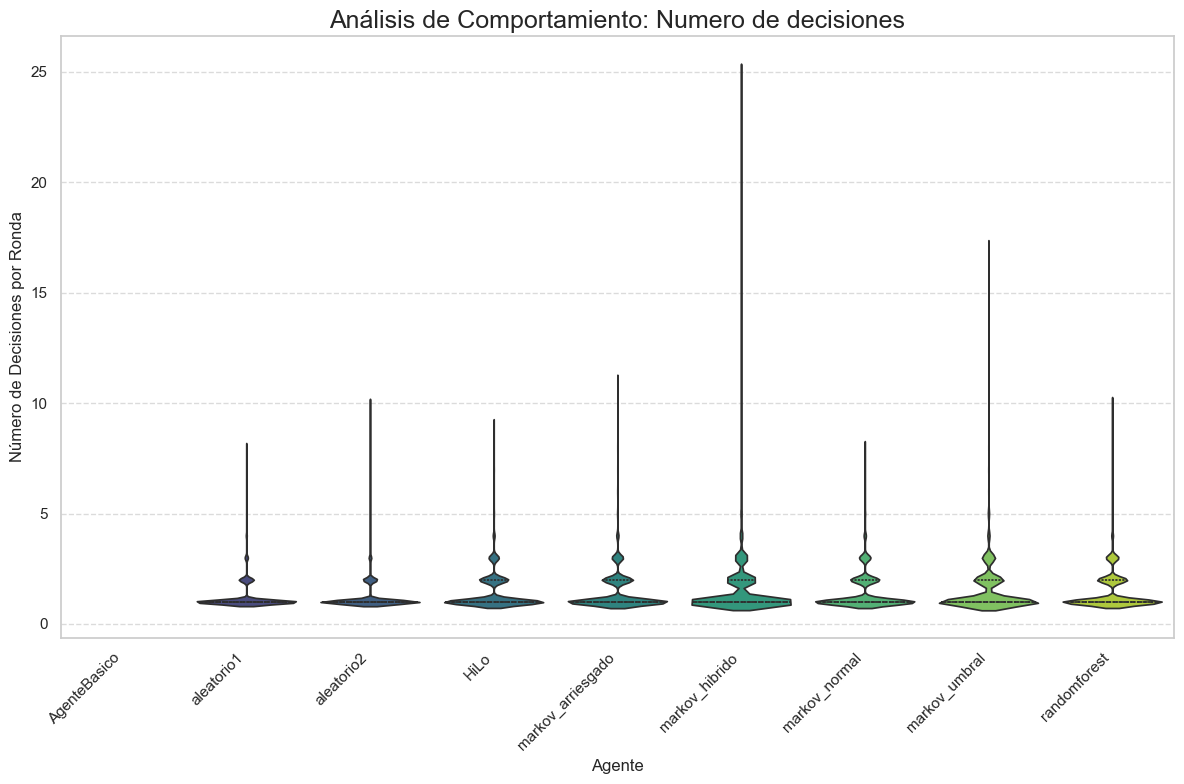

In [ ]:
# --- Gráfico A: Complejidad por Ronda (Figura Independiente) ---

plt.figure(figsize=(12, 8)) # Creamos una figura de buen tamaño para el primer gráfico
sns.violinplot(data=df_final, x='agente_nombre', y='decisions', palette='viridis', inner='quartile')

plt.title('Numero de decisiones', fontsize=18)
plt.xlabel('Agente')
plt.ylabel('Número de Decisiones por Ronda')
plt.xticks(rotation=45, ha='right') # Rotamos las etiquetas para que no se solapen
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\javie\AppData\Local\Temp\ipykernel_18360\1932129177.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_final, x='agente_nombre', y='decision_time_ms', palette='viridis', inner='quartile')


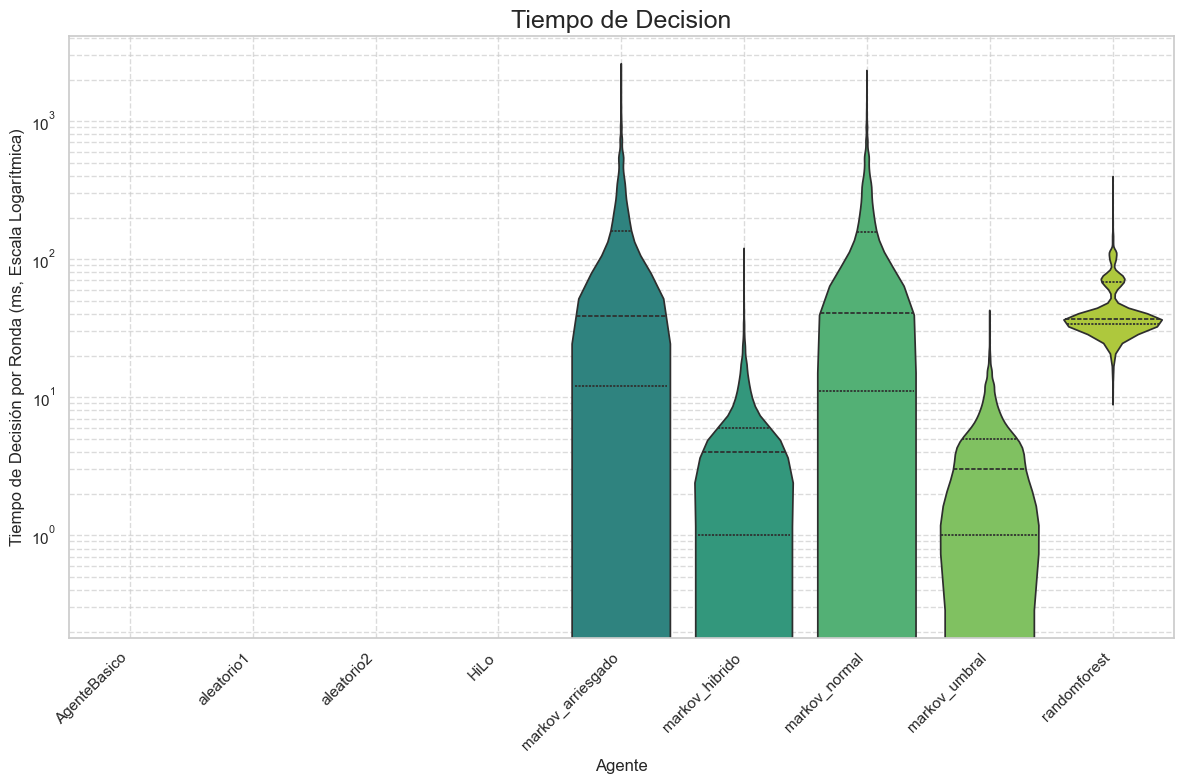

In [98]:
# --- Gráfico B: Eficiencia Computacional (Figura Independiente) ---

plt.figure(figsize=(12, 8)) # Creamos una nueva figura para el segundo gráfico
sns.violinplot(data=df_final, x='agente_nombre', y='decision_time_ms', palette='viridis', inner='quartile')

# **LA CLAVE**: Aplicamos la escala logarítmica al eje Y
plt.yscale('log')

plt.title('Tiempo de Decision', fontsize=18)
plt.xlabel('Agente')
plt.ylabel('Tiempo de Decisión por Ronda (ms, Escala Logarítmica)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', alpha=0.7) # Grid para ambos ejes, útil en escala log
plt.tight_layout()
plt.show()

C:\Users\javie\AppData\Local\Temp\ipykernel_18360\866684968.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wins_per_bin = df_wins.groupby(['agente_nombre', 'cartas_bin']).size().reset_index(name='win_count')
C:\Users\javie\AppData\Local\Temp\ipykernel_18360\866684968.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_rounds_per_bin = df_final.groupby(['agente_nombre', 'cartas_bin']).size().reset_index(name='total_rounds')


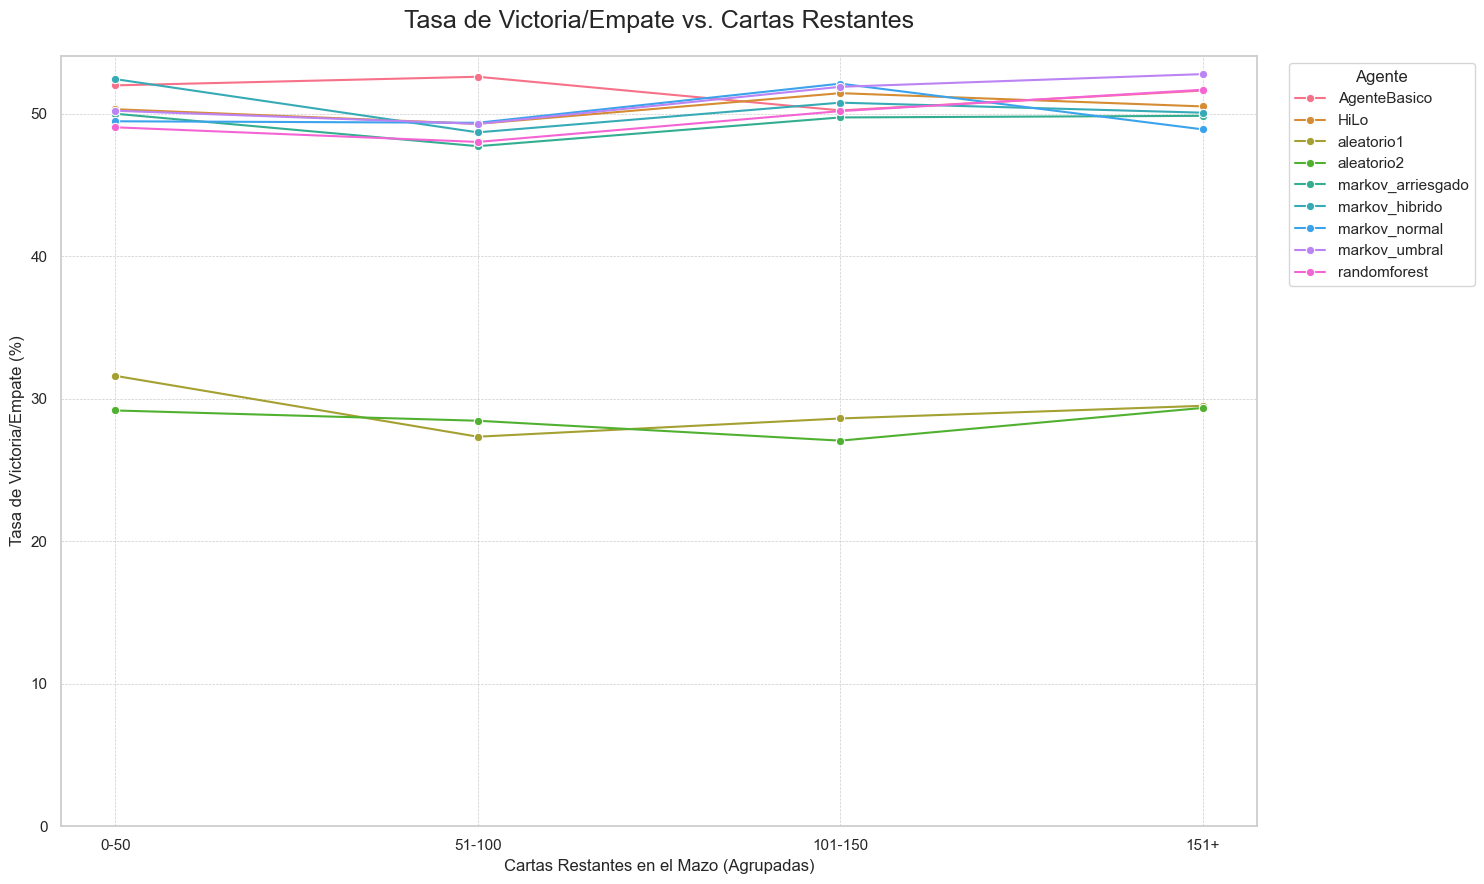

In [99]:
result_map = {-1.0: "Derrota", 0.0: "Empate", 1.0: "Victoria"}
if df_final['result'].dtype != 'object':
    df_final['result'] = df_final['result'].map(result_map)

# --- Paso 1: Agrupar (Binning) las Cartas Restantes ---
# Asumimos un zapato de 4 mazos (208 cartas), ajusta los bins si usas más o menos.
bins = [0, 50, 100, 150, float('inf')]
labels = ['0-50', '51-100', '101-150', '151+']
df_final['cartas_bin'] = pd.cut(df_final['cards_remaining'], bins=bins, labels=labels, right=False)

# --- Paso 2: Calcular la Tasa de Victoria por Bin ---
# Filtramos solo por las victorias
df_wins = df_final[df_final['result'].isin(['Victoria', 'Empate'])]

# Contamos las victorias totales en cada bin para cada agente
wins_per_bin = df_wins.groupby(['agente_nombre', 'cartas_bin']).size().reset_index(name='win_count')

# Contamos las rondas totales jugadas en cada bin para cada agente
total_rounds_per_bin = df_final.groupby(['agente_nombre', 'cartas_bin']).size().reset_index(name='total_rounds')

# Unimos los dos dataframes para tener toda la información
df_win_rate = pd.merge(wins_per_bin, total_rounds_per_bin, on=['agente_nombre', 'cartas_bin'], how='right')

# Calculamos la tasa de victoria y rellenamos con 0 si no hubo victorias en un bin
df_win_rate['win_rate_pct'] = (df_win_rate['win_count'].fillna(0) / df_win_rate['total_rounds']) * 100

# --- Paso 3: Visualizar la Tendencia ---
plt.figure(figsize=(15, 9))
sns.lineplot(data=df_win_rate, x='cartas_bin', y='win_rate_pct', hue='agente_nombre', marker='o', sort=False)

plt.title('Tasa de Victoria/Empate vs. Cartas Restantes', fontsize=18, pad=20)
plt.xlabel('Cartas Restantes en el Mazo (Agrupadas)')
plt.ylabel('Tasa de Victoria/Empate (%)')
plt.ylim(0, None) # Asegurarse que el eje Y empiece en 0
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Agente', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()